In [1]:
import glob 
import gc
import warnings
import scipy

import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt 

## custom
from dirs import wrfdir, basedir, coorddir, snoteldir, outputsdir, ucladir

plt.style.use('style.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'

warnings.filterwarnings("ignore")

/global/homes/c/cowherd/.conda/envs/resilient-snowpack-estimation/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
coords = xr.open_dataset(f'{coorddir}wrfinput_d02')
lat = coords['XLAT'][0]
lon = coords['XLONG'][0]

In [3]:
## ucla data
ucla_snotel_data = np.load(f'../../ucla_snotel_data.npy', allow_pickle = True)
ucla_cdec_data = np.load(f'../../ucla_cdec_data.npy', allow_pickle = True)
## snotel data
snotel_from_WRF_BC = xr.open_dataset(f'{basedir}/data/tmp/all_snotelWRF_365.nc').rename({'__xarray_dataarray_variable__':'swe'})


In [4]:
ucla_cdec_data = ucla_cdec_data.flatten()[0]['SWE_Reanalysis_post']
ucla_snotel_data = ucla_snotel_data.flatten()[0]['SWE_Reanalysis_post']

In [5]:
ucla_cdec_data.shape, ucla_snotel_data.shape
ucla_pillow = np.concatenate((ucla_cdec_data, ucla_snotel_data), axis=2)
ucla_pillow.shape # should be 366x37x990

(366, 37, 990)

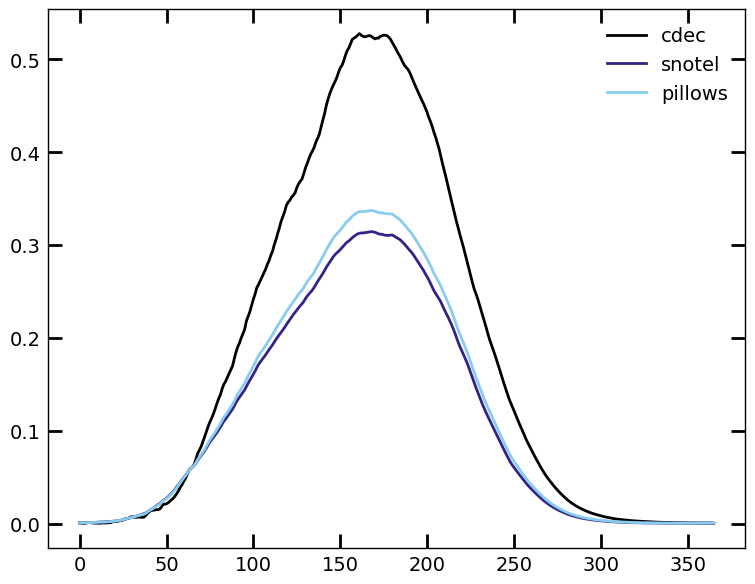

In [6]:
fig, ax = plt.subplots()
ax.plot(np.nanmean(ucla_cdec_data, axis = (1,2)), label = 'cdec')
ax.plot(np.nanmean(ucla_snotel_data, axis = (1,2)), label = 'snotel')
ax.plot(np.nanmean(ucla_pillow, axis = (1,2)), label = 'pillows')
ax.legend()
plt.show()

In [7]:
snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')

snotel_gdf = gpd.GeoDataFrame(data = {'site_name':snotelmeta.site_name,
                                     'elev': snotelmeta.elev,
                                     'site_number':snotelmeta.site_number,
                                     'state':snotelmeta.state,
                                     'namestr':snotelmeta.namestr,
                                     'startdt':snotelmeta.startdt}, geometry = gpd.points_from_xy(snotelmeta.lon, snotelmeta.lat))
snotel_no_ak = snotel_gdf[snotel_gdf.state != "AK"]


In [8]:
wrf_snotel_daily_mean = snotel_from_WRF_BC.mean(dim = 'site').mean(dim = 'gcm').swe
wrf_snotel_daily_median = snotel_from_WRF_BC.median(dim = 'site').mean(dim = 'gcm').swe

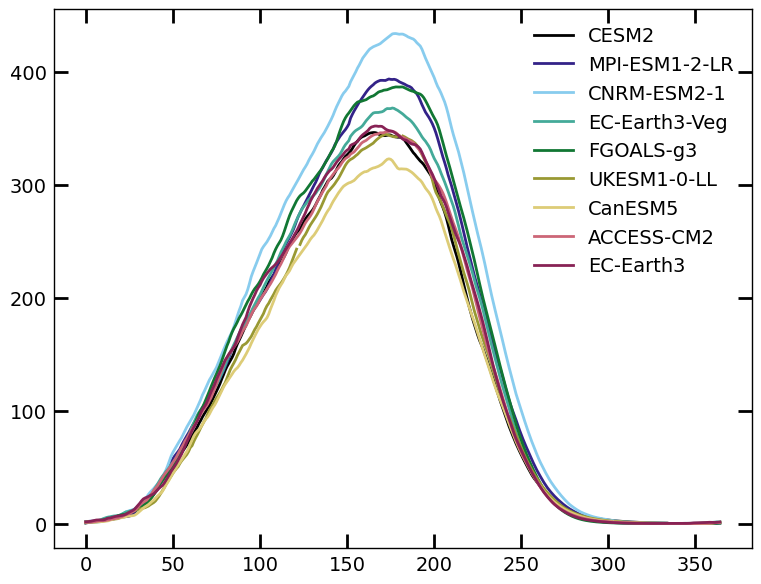

In [9]:
gcms = ['CESM2','MPI-ESM1-2-LR','CNRM-ESM2-1',
        'EC-Earth3-Veg','FGOALS-g3','UKESM1-0-LL',
        'CanESM5','ACCESS-CM2','EC-Earth3']
ig,ax = plt.subplots()
for i,gcm in enumerate(snotel_from_WRF_BC.gcm):
    tmpdata = np.roll(snotel_from_WRF_BC.sel(gcm = gcm).mean(dim = 'site').swe, shift = 92)
    tmpdata[91] = np.nanmean([tmpdata[90], tmpdata[92]])
    ax.plot(tmpdata, label = gcms[i])
ax.legend()
plt.show()

In [10]:
cdecdaily = pd.read_csv('../../cdecdaily.csv')

new_rows = []
new_rows.append({'date':1, 'SENSOR_NUMBER' : 3, 'value':15.420833})
for i in range(1,33082):
    datem1 = cdecdaily.date.iloc[i-1]
    date = cdecdaily.date.iloc[i]
    value = cdecdaily.value.iloc[i]
    old_row = {'date':date, 'SENSOR_NUMBER' : 3, 'value':value}
    mean_value = np.nanmean(cdecdaily.value.iloc[i-1:i+1])
    # 1 check if it's in order # 
    if date > 1 and datem1 != date -1:
            new_row = {'date': date-1, 'SENSOR_NUMBER': 3, 'value': mean_value}
            new_rows.append(new_row)
    if date == 1 and datem1 != 366:
            new_row = {'date': 366, 'SENSOR_NUMBER': 3, 'value': mean_value}
            new_rows.append(new_row)
    new_rows.append(old_row)
            
new_data = pd.DataFrame(new_rows)
start = 0
mydatas = []
for i in range(len(new_data)):
    date = new_data.loc[i].date
    if date == 366:
        mydata = new_data.loc[start:i]
        start = i+1
        mydatas.append(mydata)
newdfs = []
for entry in mydatas:
    values = []
    dates = []
    newdates = range(1,367)
    for i in newdates:
        if i in entry.date.values:
            dates.append(i)
            if (i > 200 and i < 300 and entry[entry.date== i].value.values[0] > 20):
                values.append(0)
            else: values.append(entry[entry.date== i].value.values[0])
        else:
            dates.append(i)
            if (i > 140 and i < 300):
                values.append(0)
            else:
                values.append(np.nan)
        
    tmpdf = pd.DataFrame({'date':dates, 'value':values})
    newdfs.append(tmpdf)

In [11]:
## what's the list of SNOTEL sites?
o_ucla_snotel_data = scipy.io.loadmat(f'{ucladir}/SNOTEL_SWE_WY1985_2021_high_res.mat')

ucla_snotels = list(o_ucla_snotel_data['SNOTEL'][0][0][0].flatten()) ## 858 stations
file_list = glob.glob(f"{snoteldir}/snotel*.csv")
print(len(file_list))
my_snotels= [fn.split('.csv')[0].split('snotel')[-1] for fn in file_list] ## 812 stations + snotelmeta
my_snotels = [int(item) for item in my_snotels if item != 'meta']
shared_entries = list(set(my_snotels).intersection(ucla_snotels))
# Find the entries that are not in one of the lists
unique_to_my_snotels = list(set(my_snotels).difference(ucla_snotels))
unique_to_ucla_snotels = list(set(ucla_snotels).difference(my_snotels))
## now make a list of ind for the shared_entries

filtered_snotel = snotel_no_ak[snotel_no_ak['site_number'].isin(shared_entries)]

points = zip(filtered_snotel.geometry.x, filtered_snotel.geometry.y)
x_indices, y_indices = [], []

for point in points:
    longitude, latitude = point
    distances = np.sqrt((lat.values - latitude) ** 2 + (lon.values - longitude) ** 2)
    min_indices = np.unravel_index(np.argmin(distances), distances.shape)
    x_indices.append(min_indices[0])
    y_indices.append(min_indices[1])


813


In [12]:
snotel_data = []
for num in shared_entries:
    file = f"{snoteldir}/snotel{num}.csv"
    df = pd.read_csv(file, parse_dates = True)
    df['Date'] = pd.to_datetime(df['datetime'])
    df = df[(df['Date'].dt.year >= 1985) & (df['Date'].dt.year <= 2015)]
    snotel_data.append(df) 
snotel_df = pd.concat([df.set_index('Date')['SWE'] for df in snotel_data], axis=1)
meansnotel = snotel_df.groupby(snotel_df.index.dayofyear).mean()

gc.collect()

0

In [13]:
cdec = pd.concat([df.set_index('date') for df in newdfs], axis=1)
snotel = meansnotel.reset_index().rename(columns = {'Date':'date'}).set_index('date')
pillows = pd.concat([snotel, cdec], axis = 1)
pillowmean = np.nanmean(pillows.values, axis = 1) * 25.4


In [14]:
def remove_leap_day(ts):
    return ts.where(ts.dayofyear != 60, drop=True) 

def interpolate_to_365(ts):
    new_index = np.linspace(1, 365, num=365, dtype=int)
    new_data = np.interp(new_index, np.arange(1, 361), ts)
    return xr.DataArray(new_data, dims=['dayofyear'], coords={'dayofyear': new_index})



fns = glob.glob('../../*_snowpillow_dialyhist.nc')
snowpillow_means = []
for fn in fns:
    data = xr.open_dataarray(fn)
    day_of_year = data.time.dt.dayofyear
    daily_avg = data.groupby(day_of_year).mean(dim='time').mean(dim = 'site').load()
    snowpillow_means.append(daily_avg)

pillows_365 = []
for d in (snowpillow_means):
    t = len(d)
    if t == 366:
        d = remove_leap_day(d)
    if t == 360:
        d = interpolate_to_365(d)
    d[-1] = np.nanmean([d[0],d[-2]])
    pillows_365.append(d)

pillows_ds = xr.concat(pillows_365, dim = 'gcm')   


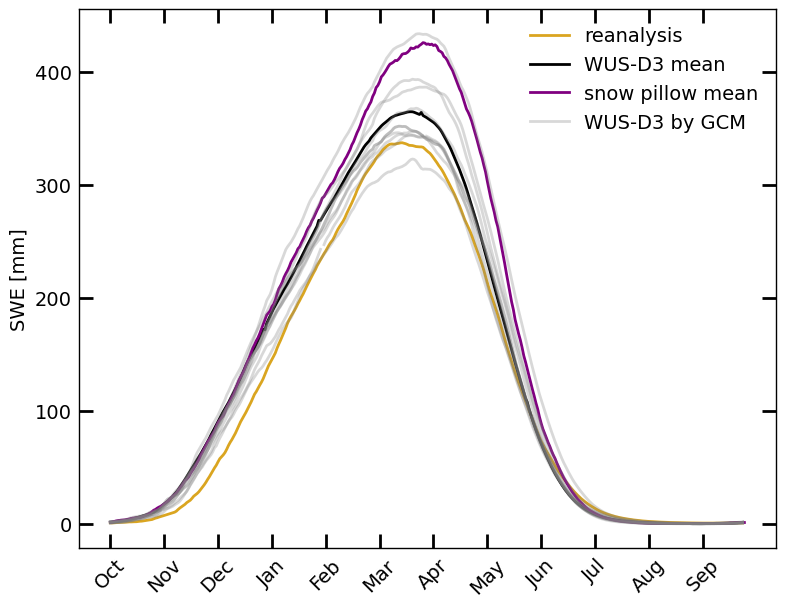

In [17]:
## make figure
wrfcolor = 'black'
snotelcolor = 'purple'
uclacolor = 'goldenrod'
## ucla data 
ucla_mean = np.nanmean(ucla_pillow, axis = (1,2)) * 1000
## snotel from WRF
shifted_wrf_mean = np.roll(wrf_snotel_daily_mean.values.flatten(), shift=90)

## pillow station data
shifted_pillowmean = np.roll(pillowmean, shift = 92)
shifted_pillowmean[91] = np.nanmean([shifted_pillowmean[92], shifted_pillowmean[90]])


## dates ## 

x = np.arange(365)  # 0 to 364

# Create a list of month labels
month_labels = ['Oct', 'Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
## 

fig,ax = plt.subplots()
ax.plot(x, ucla_mean [0:365] , label = 'reanalysis', color = uclacolor)
# ax.plot(x, shifted_snotel_mean[0:365] , label = 'SNOTEL', color = snotelcolor)
ax.plot(shifted_wrf_mean, label = 'WUS-D3 mean', color = wrfcolor)

ax.plot(shifted_pillowmean, label = 'snow pillow mean', color = snotelcolor)

for gcm in snotel_from_WRF_BC.gcm:
    tmpdata = np.roll(snotel_from_WRF_BC.sel(gcm = gcm).mean(dim = 'site').swe, shift = 92)
    tmpdata[91] = np.nanmean([tmpdata[90], tmpdata[92]])
    ax.plot(tmpdata, color = 'gray', alpha = 0.3)
ax.plot(tmpdata, color = 'gray', alpha = 0.3, label = 'WUS-D3 by GCM')

    
ax.set_ylabel('SWE [mm]')
ax.legend()
ax.set_xticks(np.arange(0, 365, 31), month_labels, rotation=45)

fig.savefig(f'{basedir}/figures/ext_climatology.jpg', dpi = 400)

plt.show()

